In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pandas import ExcelWriter
import re
import time
import textwrap
from tqdm.notebook import tqdm
from pathlib2 import Path
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.pylab as pylab
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 
#plt.style.use('ggplot')
%matplotlib inline

### Event prediction 1D

In [2]:
def get_metric_sets_for_graph(graph_option, base_metric, suff, window, path_to_files):
    metric_sets_pairs = [f'{base_metric}', f'{base_metric} + LCC_{suff}', f'{base_metric} + degree_{suff}',
                         f'{base_metric} + closeness_{suff}', f'{base_metric} + EVC_{suff}']
    
    adding_metrics_order = pd.read_csv(f'{path_to_files}/ep1D_{base_metric}_metrics_{suff}_{int(window/8)}m8w_metrics_order.txt')
    metrics_priority =  adding_metrics_order['metrics_priority'].values
    metric_sets_add = [metrics_priority[0:i+1] for i in range(0, len(metrics_priority))]
    metric_sets_adding_priority = [f'{base_metric}'] + [" + ".join([f'{base_metric}'] + [f'{mm}_{suff}' for mm in metric_sets_add[k]]) for k in range(0, len(metric_sets_add))]

    if graph_option == 1:
        return metric_sets_pairs, 'pairs'
    elif graph_option == 2:
        return metric_sets_adding_priority, 'adding_priority'
    elif graph_option == 3:
        return metric_sets_pairs + metric_sets_adding_priority, 'pairs and adding_priority'

    
def plot_graphics_for_ep1D(ax, graph_option, global_path, suff, base_metric, window):
    folder = f'{base_metric}_metrics_{suff}_{int(window/8)}m8w'
    path = f'{global_path}/{folder}'
    print(path)

    considered_files = [f'{base_metric}_{int(window/8)}m8w', 
                        f'{base_metric}_1metric_{suff}_{int(window/8)}m8w', 
                        f'{base_metric}_metrics_{suff}_{int(window/8)}m8w'] 
    print(considered_files)

    metric_sets, type_sets = get_metric_sets_for_graph(graph_option, base_metric, suff, window, path)
    print(metric_sets)

    quality_names = ['g_stat', 'f1', 'bacc', 'mcc']
    yname = {'g_stat': 'g-statistics', 'f1': 'F1-score', 'bacc': 'balanced accuracy', 'mcc': 'matthews coefficient'}
    colors = ['r', 'b', 'g', 'm', 'orange', 'c', 'gray', 'pink', 'y']

    

    ax[0].set(title=suff, ylabel=yname['g_stat'])
    ax[1].set(title=suff, ylabel=yname['f1'])
    ax[2].set(title=suff, ylabel=yname['bacc'])
    ax[3].set(title=suff, ylabel=yname['mcc'])
    ax[4].set(title=suff, xlabel='False Positive Rate', ylabel='True Positive Rate')

    i = 0
    xlabels = []
    for file_suffix in considered_files:
        print(file_suffix)
        file = pd.ExcelFile(f'{path}/ep1D_{file_suffix}.xlsx', engine='openpyxl')
        subsets = file.sheet_names
        for subset in subsets:
            df = file.parse(subset)
            metrics = df['metrics_subset'].unique()[0]
            metrics = metrics.replace("[", "")
            metrics = metrics.replace("]", "")
            metrics = metrics.replace("'", "")
            metrics = metrics.split(", ")
            text = ''
            for m in metrics:
                text += m.split('/')[-1] + " + "
            text = text[:-3]

            if text in metric_sets:
                zeros = np.where(np.array(eval(df['weights'][0])) == 0.0)[0]
                if len(zeros) > 0:
                    tmp = text.split(' + ')
                    for ind_zero in zeros:
                        tmp[ind_zero] = '\u0336' + '\u0336'.join(tmp[ind_zero] + ' ') + '\u0336'
                    text = ' + '.join(tmp)

                ax[0].bar(i, df['g_stat'][0], color=colors[i])
                ax[1].bar(i, df['f1'][0], color=colors[i])
                ax[2].bar(i, df['bacc'][0], color=colors[i])
                ax[3].bar(i, df['mcc'][0], color=colors[i])
                ax[4].plot(df['FPR'][0], df['TPR'][0], 'o', markersize=10, color=colors[i], label=text)
                xlabels.append('\n'.join(text.split(' + ')))
                i += 1

    ax[0].set(xticks=range(0, i), xticklabels=xlabels)
    ax[0].tick_params(axis='x', labelsize=8)
    ax[1].set(xticks=range(0, i), xticklabels=xlabels)
    ax[1].tick_params(axis='x', labelsize=8)
    ax[2].set(xticks=range(0, i), xticklabels=xlabels)
    ax[2].tick_params(axis='x', labelsize=8)
    ax[3].set(xticks=range(0, i), xticklabels=xlabels)
    ax[3].tick_params(axis='x', labelsize=8)
    ax[4].set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
    ax[4].legend(loc='lower right')


    ax[0].set(ylim=(0, 450))
    ax[1].set(ylim=(0, 0.225))
    ax[2].set(ylim=(0, 0.80))
    ax[3].set(ylim=(0, 0.25))

C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ep1D/MSLP_preproc_metrics_w_1m8w
['MSLP_preproc_1m8w', 'MSLP_preproc_1metric_w_1m8w', 'MSLP_preproc_metrics_w_1m8w']
['MSLP_preproc', 'MSLP_preproc + LCC_w', 'MSLP_preproc + degree_w', 'MSLP_preproc + closeness_w', 'MSLP_preproc + EVC_w', 'MSLP_preproc', 'MSLP_preproc + LCC_w', 'MSLP_preproc + LCC_w + closeness_w', 'MSLP_preproc + LCC_w + closeness_w + degree_w', 'MSLP_preproc + LCC_w + closeness_w + degree_w + EVC_w']
MSLP_preproc_1m8w
MSLP_preproc_1metric_w_1m8w
MSLP_preproc_metrics_w_1m8w
C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ep1D/MSLP_preproc_metrics_0.95_1m8w
['MSLP_preproc_1m8w', 'MSLP_preproc_1metric_0.95_1m8w', 'MSLP_preproc_metrics_0.95_1m8w']
['MSLP_preproc', 'MSLP_preproc + LCC_0.95', 'MSLP_preproc + degree_0.95', 'MSLP_preproc + closeness_0.95', 'MSLP_preproc + EVC_

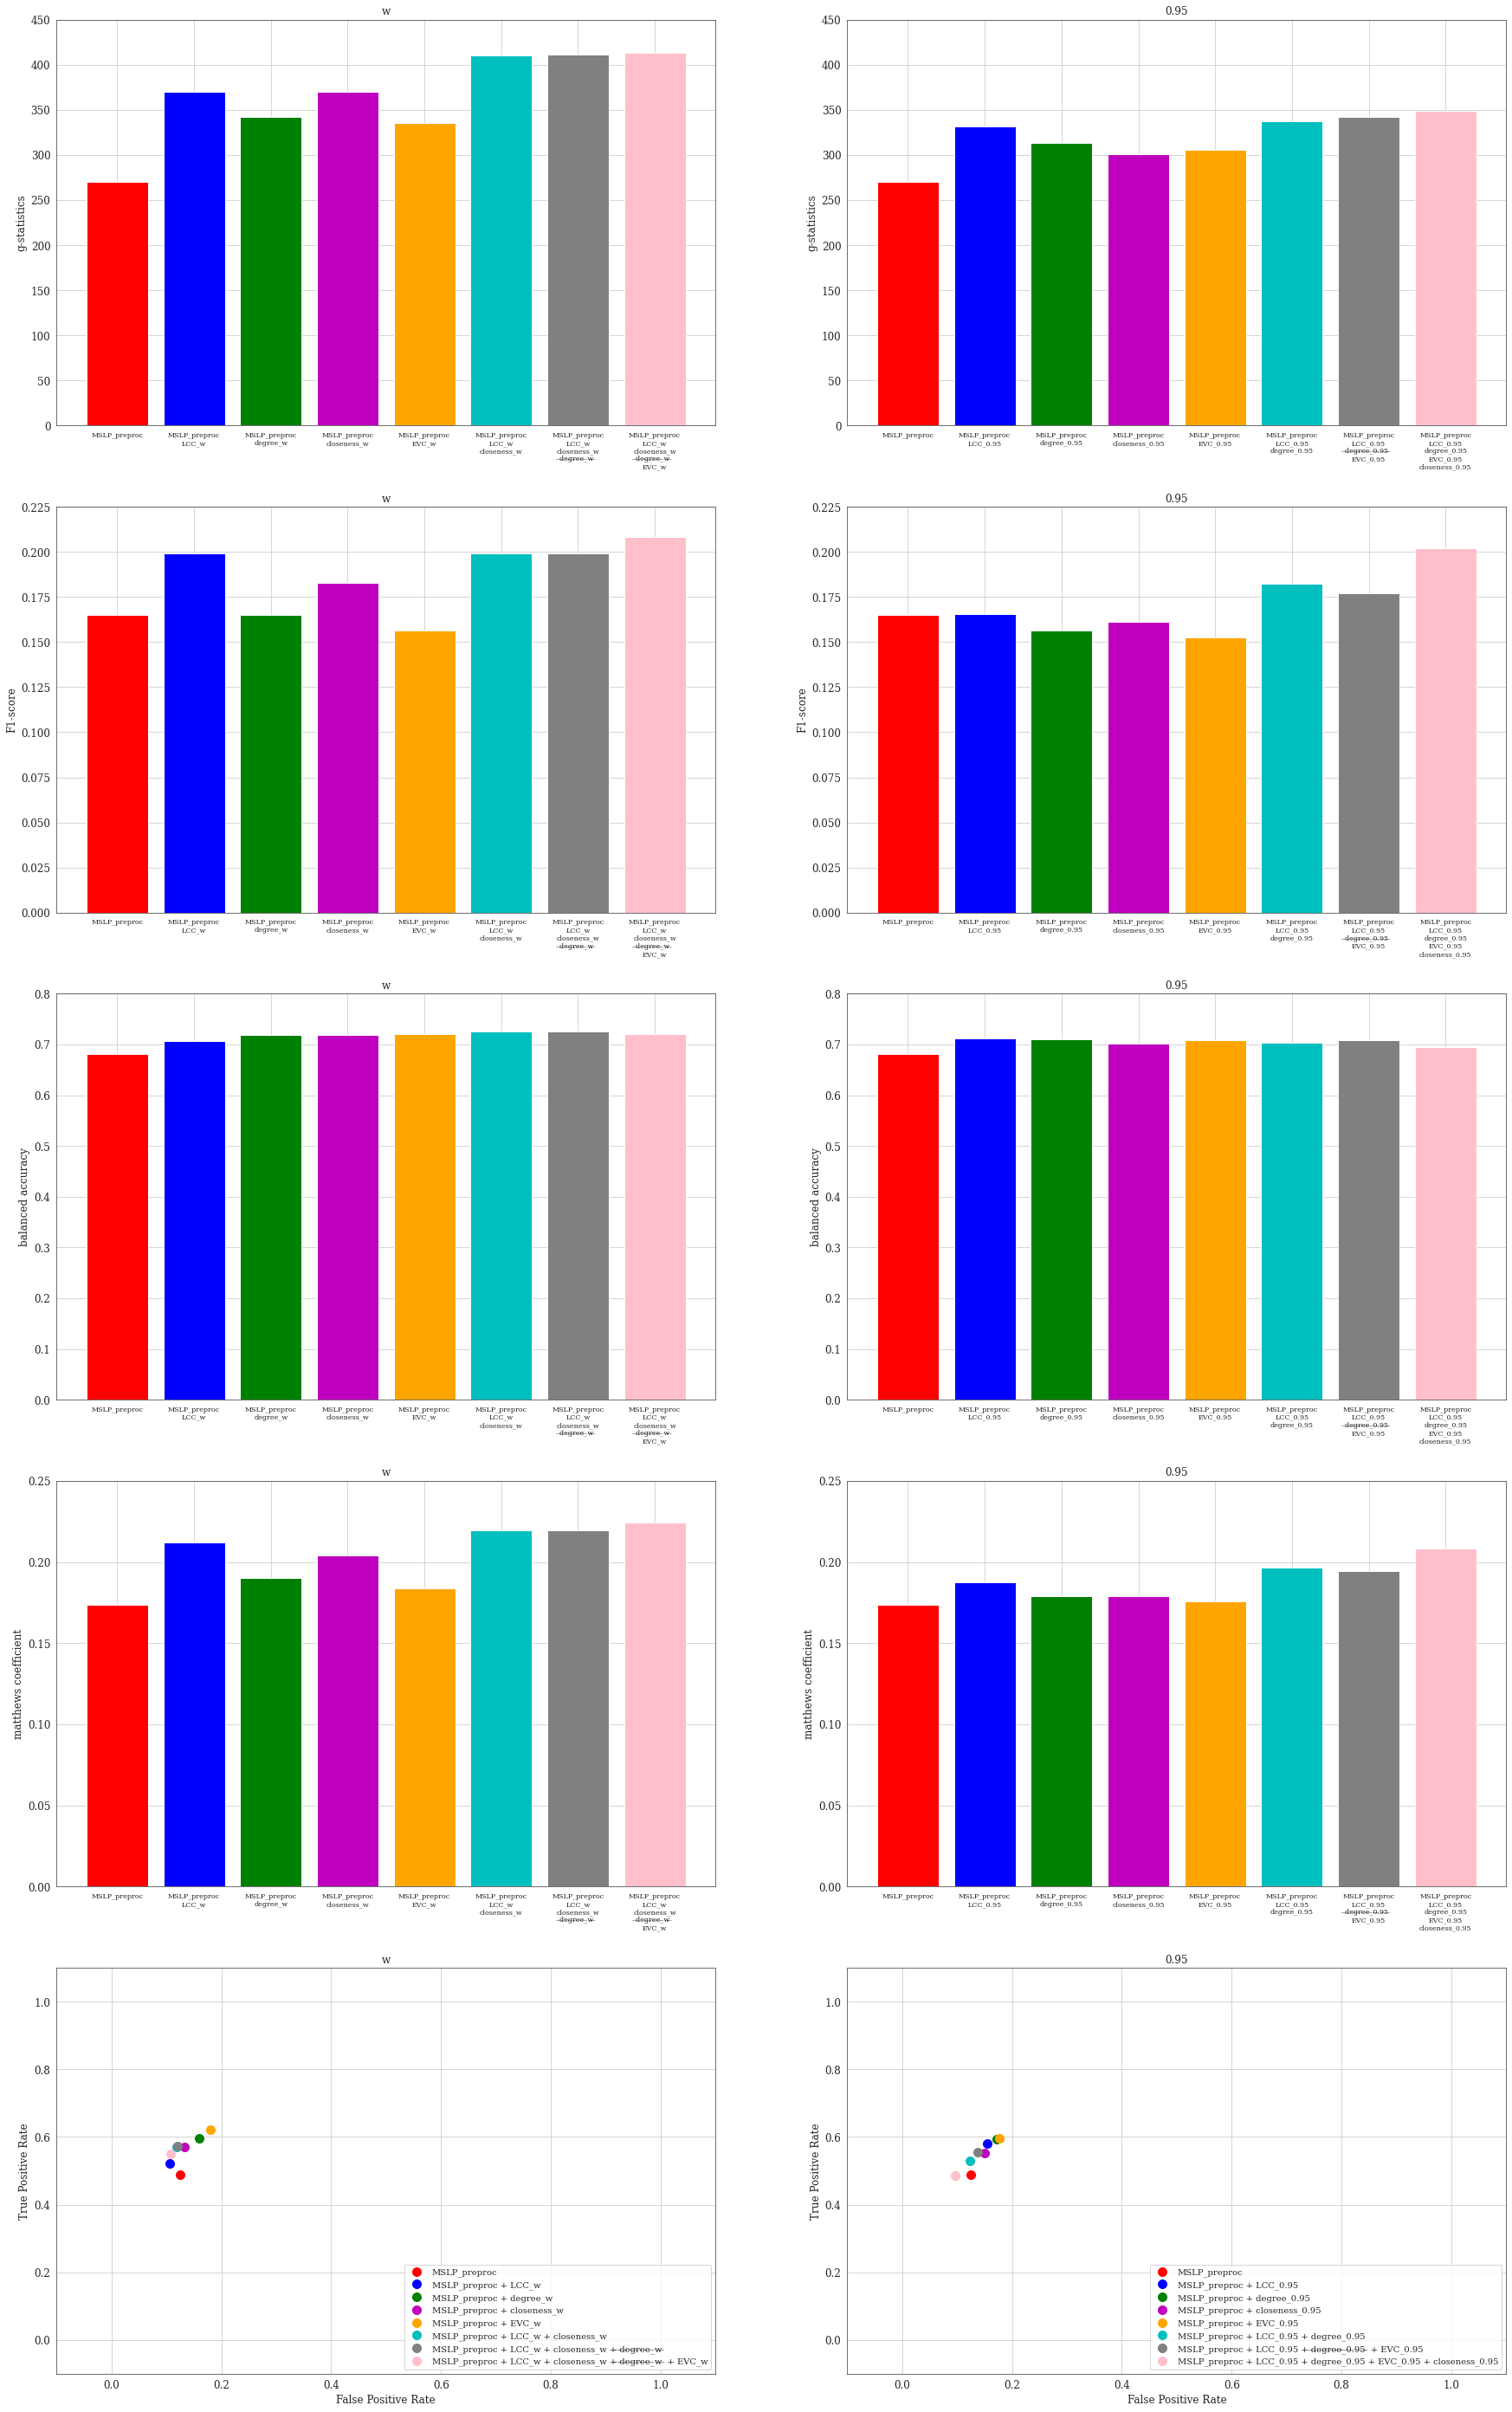

In [3]:
window = 1*8                  # 1*8 = 1 day; 2*8 = 2 day
base_metric = 'MSLP_preproc'  # MSLP or MSLP_preproc

global_path = r'C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ep1D'  

graph_option = 3 #int(input())

fig, axes = plt.subplots(5, 2, figsize=(30, 50))

plot_graphics_for_ep1D([axes[0][0], axes[1][0], axes[2][0], axes[3][0], axes[4][0]], 
                       graph_option, global_path, 'w', base_metric, window)
plot_graphics_for_ep1D([axes[0][1], axes[1][1], axes[2][1], axes[3][1], axes[4][1]], 
                       graph_option, global_path, '0.95', base_metric, window)

directory = f'{global_path}/Pictures/'
if not os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

fig.savefig(f'{directory}/ep1D_w_vs_0.95.pdf', dpi=600, format='pdf', bbox_inches='tight')

In [ ]:
'''
window = 1*8                  # 1*8 = 1 day; 2*8 = 2 day
base_metric = 'MSLP_preproc'  # MSLP or MSLP_preproc
suff = '0.95'                    # 'w' or '0.9' or '0.95'

global_path = r'C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ep1D'  

folder = f'{base_metric}_metrics_{suff}_{int(window/8)}m8w'
path = f'{global_path}/{folder}'

considered_files = [f'{base_metric}_{int(window/8)}m8w', 
                    f'{base_metric}_1metric_{suff}_{int(window/8)}m8w', 
                    f'{base_metric}_metrics_{suff}_{int(window/8)}m8w'] 


graph_option = int(input())
metric_sets, type_sets = get_metric_sets_for_graph(graph_option, base_metric, suff, window, path)
print(metric_sets)


quality_names = ['g_stat', 'f1', 'bacc', 'mcc']
yname = {'g_stat': 'g-statistics', 'f1': 'F1-score', 'bacc': 'balanced accuracy', 'mcc': 'matthews coefficient'}
colors = ['r', 'b', 'g', 'm', 'orange', 'c', 'gray', 'pink', 'y']


directory = f'{path}/Pictures/{type_sets}'
if not os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.set(title=suff, ylabel=yname['g_stat'])
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.set(title=suff, ylabel=yname['f1'])
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 6))
ax3.set(title=suff, ylabel=yname['bacc'])
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 6))
ax4.set(title=suff, ylabel=yname['mcc'])
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 6))
ax5.set(title=suff, xlabel='False Positive Rate', ylabel='True Positive Rate')

i = 0
xlabels = []
for file_suffix in considered_files:
    print(file_suffix)
    file = pd.ExcelFile(f'{path}/ep1D_{file_suffix}.xlsx', engine='openpyxl')
    subsets = file.sheet_names
    for subset in subsets:
        df = file.parse(subset)
        metrics = df['metrics_subset'].unique()[0]
        metrics = metrics.replace("[", "")
        metrics = metrics.replace("]", "")
        metrics = metrics.replace("'", "")
        metrics = metrics.split(", ")
        text = ''
        for m in metrics:
            text += m.split('/')[-1] + " + "
        text = text[:-3]
        
        if text in metric_sets:
            zeros = np.where(np.array(eval(df['weights'][0])) == 0.0)[0]
            if len(zeros) > 0:
                tmp = text.split(' + ')
                for ind_zero in zeros:
                    tmp[ind_zero] = '\u0336' + '\u0336'.join(tmp[ind_zero] + ' ') + '\u0336'
                text = ' + '.join(tmp)
                
            ax1.bar(i, df['g_stat'][0], color=colors[i])
            ax2.bar(i, df['f1'][0], color=colors[i])
            ax3.bar(i, df['bacc'][0], color=colors[i])
            ax4.bar(i, df['mcc'][0], color=colors[i])
            ax5.plot(df['FPR'][0], df['TPR'][0], 'o', markersize=10, color=colors[i], label=text)
            xlabels.append('\n'.join(text.split(' + ')))
            i += 1
            
ax1.set(xticks=range(0, i), xticklabels=xlabels)
ax1.tick_params(axis='x', labelsize=8)
ax2.set(xticks=range(0, i), xticklabels=xlabels)
ax2.tick_params(axis='x', labelsize=8)
ax3.set(xticks=range(0, i), xticklabels=xlabels)
ax3.tick_params(axis='x', labelsize=8)
ax4.set(xticks=range(0, i), xticklabels=xlabels)
ax4.tick_params(axis='x', labelsize=8)

ax5.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
ax5.legend(loc='lower right')


ax1.set(ylim=(0, 450))
ax2.set(ylim=(0, 0.225))
ax3.set(ylim=(0, 0.80))
ax4.set(ylim=(0, 0.25))

plt.show()


fig1.savefig(f'{directory}/1 - g_stat for {type_sets} barplot.png', dpi=600, bbox_inches='tight')
fig2.savefig(f'{directory}/2 - f1 for {type_sets} barplot.png', dpi=600, bbox_inches='tight')
fig3.savefig(f'{directory}/3 - bacc for {type_sets} barplot.png', dpi=600, bbox_inches='tight')
fig4.savefig(f'{directory}/4 - mcc for {type_sets} barplot.png', dpi=600, bbox_inches='tight')
fig5.savefig(f'{directory}/5 - TPR vs FPR for {type_sets}.png', dpi=600, bbox_inches='tight')
'''

### Multi-metric event association 2D

In [4]:
def get_metric_sets_for_graph(graph_option, base_metric, suff, window, path_to_files):
    metric_sets_pairs = [f'{base_metric}', f'{base_metric} + LCC_{suff}', f'{base_metric} + degree_{suff}',
                         f'{base_metric} + closeness_{suff}', f'{base_metric} + EVC_{suff}']
    
    adding_metrics_order = pd.read_csv(f'{path_to_files}/ea2D_{base_metric}_metrics_{suff}_metrics_order.txt')
    metrics_priority =  adding_metrics_order['metrics_priority'].values
    metric_sets_add = [metrics_priority[0:i+1] for i in range(0, len(metrics_priority))]
    metric_sets_adding_priority = [f'{base_metric}'] + [" + ".join([f'{base_metric}'] + [f'{mm}_{suff}' for mm in metric_sets_add[k]]) for k in range(0, len(metric_sets_add))]

    if graph_option == 1:
        return metric_sets_pairs, 'pairs'
    elif graph_option == 2:
        return metric_sets_adding_priority, 'adding_priority'
    elif graph_option == 3:
        return metric_sets_pairs + metric_sets_adding_priority, 'pairs and adding_priority'
    

def plot_graphics_for_ea2D(ax1, ax2, graph_option, global_path, suff, base_metric, window):
    folder = f'{base_metric}_and_metrics_{suff}'
    path = f'{global_path}/{folder}'

    considered_files = [f'{base_metric}', 
                        f'{base_metric}_1metric_{suff}', 
                        f'{base_metric}_metrics_{suff}'] 

    metric_sets, type_sets = get_metric_sets_for_graph(graph_option, base_metric, suff, window, path)
    print(metric_sets)


    quality_names = ['g_stat', 'f1', 'bacc', 'mcc']
    yname = {'g_stat': 'g-statistics', 'f1': 'F1-score', 'bacc': 'balanced accuracy', 'mcc': 'matthews coefficient'}
    colors = ['r', 'b', 'g', 'm', 'orange', 'c', 'gray', 'pink', 'y']

    ax1[0].set(title=suff, ylabel=yname['g_stat'], xlabel='track size')
    ax1[1].set(title=suff, ylabel=yname['f1'], xlabel='track size')
    ax1[2].set(title=suff, ylabel=yname['bacc'], xlabel='track size')
    ax1[3].set(title=suff, ylabel=yname['mcc'], xlabel='track size')
            
    i = 0
    labels = []
    for file_suffix in considered_files:
        print(file_suffix)
        file = pd.ExcelFile(f'{path}/ea2D_{file_suffix}.xlsx', engine='openpyxl')
        subsets = file.sheet_names
        for subset in subsets:
            df = file.parse(subset)
            track_sizes = df['track_size'].values
            metrics = df['metrics_subset'].unique()[0]
            metrics = metrics.replace("[", "")
            metrics = metrics.replace("]", "")
            metrics = metrics.replace("'", "")
            metrics = metrics.split(", ")
            text = ''
            for m in metrics:
                text += m.split('/')[-1] + " + "
            text = text[:-3]

            if text in metric_sets:
                ax1[0].plot(track_sizes, df['g_stat'].values, 'o-', color=colors[i], label=text)
                ax1[0].set(ylim=[0, 2100000])
                ax1[1].plot(track_sizes, df['f1'].values, 'o-', color=colors[i], label=text)
                ax1[1].set(ylim=[0, 0.20])
                ax1[2].plot(track_sizes, df['bacc'].values, 'o-', color=colors[i], label=text)
                ax1[2].set(ylim=[0.7, 0.9])
                ax1[3].plot(track_sizes, df['mcc'].values, 'o-', color=colors[i], label=text)
                ax1[3].set(ylim=[0, 0.26])

                points = []
                for ts in range(0, len(track_sizes)):
                    p = ax2[ts].plot(df['FPR'][ts], df['TPR'][ts], 'o', markersize=10, color=colors[i], label=text)[0]
                    points.append(p)
                    ax2[ts].set(xlim=(-0.1, 1.1), xscale='log', ylim=(10**(-3), 10**(0)), title=f'{suff} - track size = {track_sizes[ts]}')
                    ax2[ts].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
                    ax2[ts].set(xticks=[10**(-3), 10**(-2), 10**(-1), 10**(0)], 
                                xticklabels=[r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
                    ax2[ts].legend(loc=4)

                labels.append(text)

                i += 1

    ax1[0].legend(loc=4)
    ax1[1].legend(loc=4)
    ax1[2].legend(loc=1)
    ax1[3].legend(loc=4)

['MSLP_preproc', 'MSLP_preproc + LCC_w', 'MSLP_preproc + degree_w', 'MSLP_preproc + closeness_w', 'MSLP_preproc + EVC_w', 'MSLP_preproc', 'MSLP_preproc + LCC_w', 'MSLP_preproc + LCC_w + degree_w', 'MSLP_preproc + LCC_w + degree_w + closeness_w', 'MSLP_preproc + LCC_w + degree_w + closeness_w + EVC_w']
MSLP_preproc
MSLP_preproc_1metric_w


<ipython-input-4-292491b487c6>:72: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax2[ts].set(xlim=(-0.1, 1.1), xscale='log', ylim=(10**(-3), 10**(0)), title=f'{suff} - track size = {track_sizes[ts]}')


MSLP_preproc_metrics_w
['MSLP_preproc', 'MSLP_preproc + LCC_0.95', 'MSLP_preproc + degree_0.95', 'MSLP_preproc + closeness_0.95', 'MSLP_preproc + EVC_0.95', 'MSLP_preproc', 'MSLP_preproc + closeness_0.95', 'MSLP_preproc + closeness_0.95 + degree_0.95', 'MSLP_preproc + closeness_0.95 + degree_0.95 + EVC_0.95', 'MSLP_preproc + closeness_0.95 + degree_0.95 + EVC_0.95 + LCC_0.95']
MSLP_preproc
MSLP_preproc_1metric_0.95
MSLP_preproc_metrics_0.95


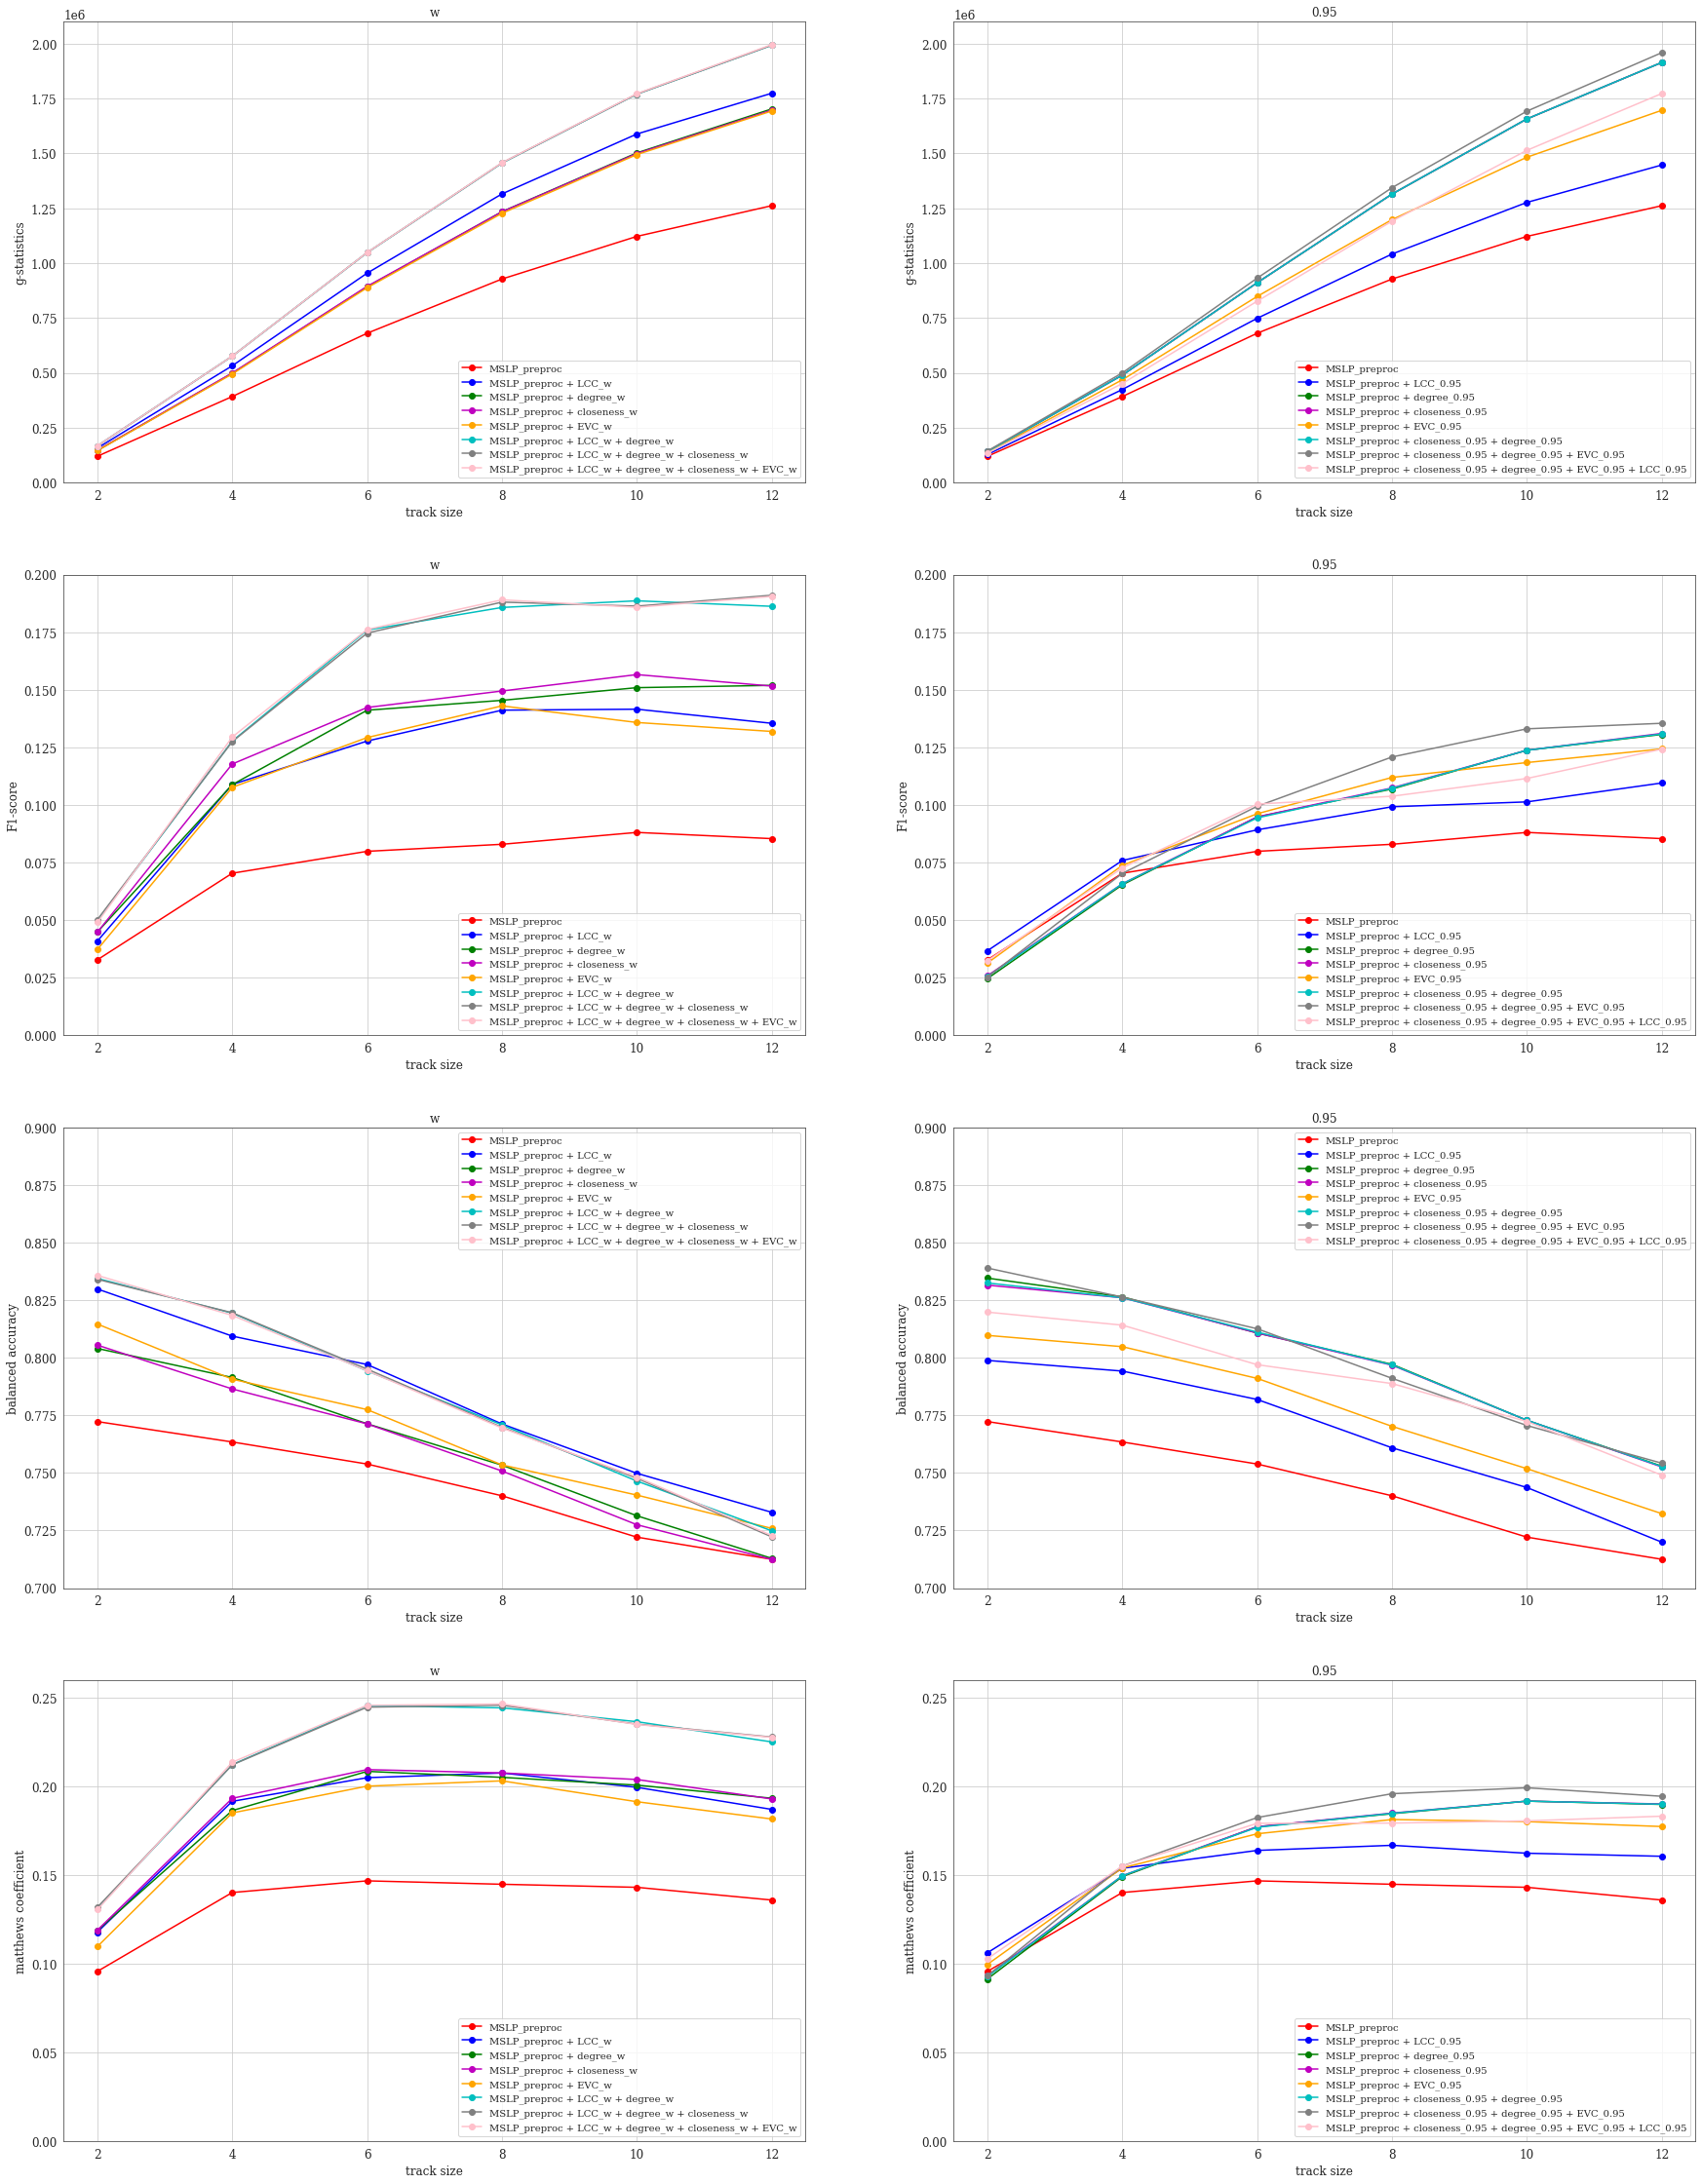

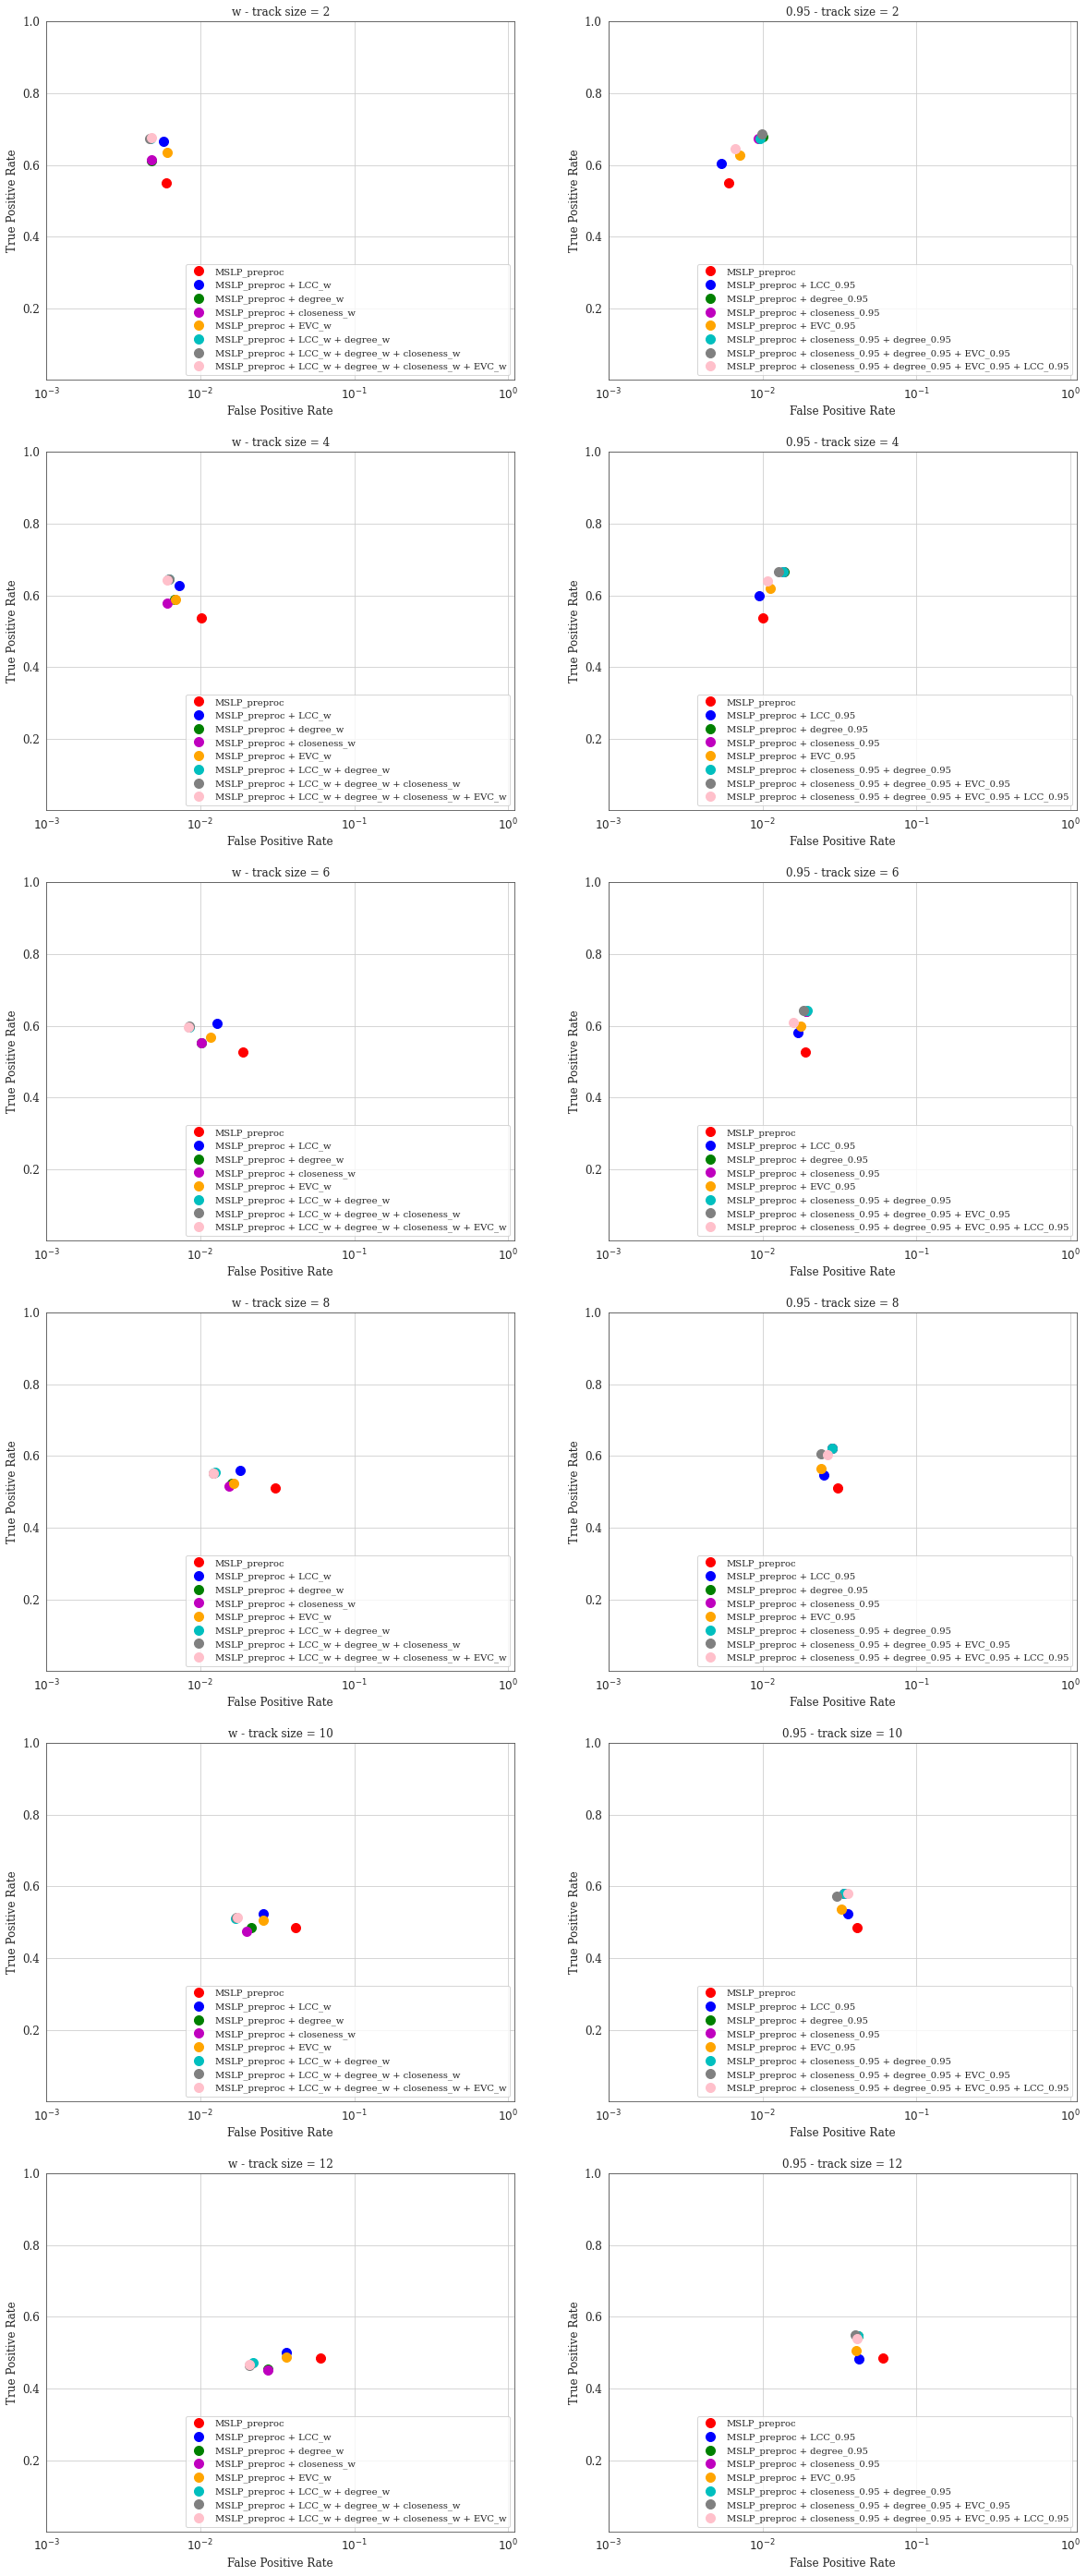

In [5]:
ow = 1*8                  # 1*8 = 1 day; 2*8 = 2 day
base_metric = 'MSLP_preproc'  # MSLP or MSLP_preproc

global_path = r'C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ea2D'  

graph_option = 3 #int(input())

fig1, axes1 = plt.subplots(4, 2, figsize=(30, 40))
fig2, axes2 = plt.subplots(6, 2, figsize=(20, 50))

plot_graphics_for_ea2D([axes1[0][0], axes1[1][0], axes1[2][0], axes1[3][0]],
                       [axes2[0][0], axes2[1][0], axes2[2][0], axes2[3][0], axes2[4][0], axes2[5][0]],
                       graph_option, global_path, 'w', base_metric, window)
plot_graphics_for_ea2D([axes1[0][1], axes1[1][1], axes1[2][1], axes1[3][1]],
                       [axes2[0][1], axes2[1][1], axes2[2][1], axes2[3][1], axes2[4][1], axes2[5][1]],
                       graph_option, global_path, '0.95', base_metric, window)

directory = f'{global_path}/Pictures/'
if not os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

fig1.savefig(f'{directory}/ea2D_w_vs_0.95.pdf', dpi=600, format='pdf', bbox_inches='tight')
fig2.savefig(f'{directory}/ea2D_w_vs_0.95_tpr_vs_fpr.pdf', dpi=600, format='pdf', bbox_inches='tight')

In [ ]:
'''
window = 1*8                  # 1*8 = 1 day; 2*8 = 2 day
base_metric = 'MSLP_preproc'  # MSLP or MSLP_preproc
suff = 'w'                    # 'w' or '0.9' or '0.95'

global_path = r'C:\Users\olga\GitRep\climate-networks\src\ERA5\ERA5_MSL_1982_2020_3h_0.75\results_land_masked_and_preproc_window_2d_delay_0d\ea2D'  

folder = f'{base_metric}_and_metrics_{suff}'
path = f'{global_path}/{folder}'

considered_files = [f'{base_metric}', 
                    f'{base_metric}_1metric_{suff}', 
                    f'{base_metric}_metrics_{suff}'] 


graph_option = int(input())
metric_sets, type_sets = get_metric_sets_for_graph(graph_option, base_metric, suff, window, path)
print(metric_sets)


quality_names = ['g_stat', 'f1', 'bacc', 'mcc']
yname = {'g_stat': 'g-statistics', 'f1': 'F1-score', 'bacc': 'balanced accuracy', 'mcc': 'matthews coefficient'}
colors = ['r', 'b', 'g', 'm', 'orange', 'c', 'gray', 'pink', 'y']


directory = f'{path}/Pictures/{type_sets}'
if not os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)


fig1, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax1.set(title=suff, ylabel=yname['g_stat'], xlabel='track size')
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.set(title=suff, ylabel=yname['f1'], xlabel='track size')
fig3, ax3 = plt.subplots(1, 1, figsize=(10, 6))
ax3.set(title=suff, ylabel=yname['bacc'], xlabel='track size')
fig4, ax4 = plt.subplots(1, 1, figsize=(10, 6))
ax4.set(title=suff, ylabel=yname['mcc'], xlabel='track size')
fig5, ax5 = plt.subplots(1, 6, figsize=(24, 3))
fig5.suptitle(suff)
            

i = 0
labels = []
for file_suffix in considered_files:
    print(file_suffix)
    file = pd.ExcelFile(f'{path}/ea2D_{file_suffix}.xlsx', engine='openpyxl')
    subsets = file.sheet_names
    for subset in subsets:
        df = file.parse(subset)
        track_sizes = df['track_size'].values
        metrics = df['metrics_subset'].unique()[0]
        metrics = metrics.replace("[", "")
        metrics = metrics.replace("]", "")
        metrics = metrics.replace("'", "")
        metrics = metrics.split(", ")
        text = ''
        for m in metrics:
            text += m.split('/')[-1] + " + "
        text = text[:-3]
        
        if text in metric_sets:
            
            #zeros = np.where(np.array(eval(df['weights'][0])) == 0.0)[0]
            #if len(zeros) > 0:
                #tmp = text.split(' + ')
                #for ind_zero in zeros:
                    #tmp[ind_zero] = '\u0336' + '\u0336'.join(tmp[ind_zero] + ' ') + '\u0336'
                #text = ' + '.join(tmp)
            
            ax1.plot(track_sizes, df['g_stat'].values, 'o-', color=colors[i], label=text)
            ax1.set(ylim=[0, 2100000])
            ax2.plot(track_sizes, df['f1'].values, 'o-', color=colors[i], label=text)
            ax2.set(ylim=[0, 0.20])
            ax3.plot(track_sizes, df['bacc'].values, 'o-', color=colors[i], label=text)
            ax3.set(ylim=[0.7, 0.9])
            ax4.plot(track_sizes, df['mcc'].values, 'o-', color=colors[i], label=text)
            ax4.set(ylim=[0, 0.26])
            
            points = []
            for ts in range(0, len(track_sizes)):
                p = ax5[ts].plot(df['FPR'][ts], df['TPR'][ts], 'o', markersize=10, color=colors[i], label=text)[0]
                points.append(p)
                ax5[ts].set(xlim=(-0.1, 1.1), xscale='log', ylim=(10**(-3), 10**(0)), title=f'track size = {track_sizes[ts]}')
                ax5[ts].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
                ax5[ts].set(xticks=[10**(-3), 10**(-2), 10**(-1), 10**(0)], 
                            xticklabels=[r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
            
            labels.append(text)
            
            i += 1

ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=1)
ax4.legend(loc=4)

lines, labels = fig5.axes[0].get_legend_handles_labels()
fig5.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
fig5.subplots_adjust(wspace=0.4)

plt.show()


fig1.savefig(f'{directory}/1 - g_stat for {type_sets}.png', dpi=600, bbox_inches='tight')
fig2.savefig(f'{directory}/2 - f1 for {type_sets}.png', dpi=600, bbox_inches='tight')
fig3.savefig(f'{directory}/3 - bacc for {type_sets}.png', dpi=600, bbox_inches='tight')
fig4.savefig(f'{directory}/4 - mcc for {type_sets}.png', dpi=600, bbox_inches='tight')
fig5.savefig(f'{directory}/5 - TPR vs FPR for {type_sets}.png', dpi=600, bbox_inches='tight')
'''